# Imports

In [114]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
%matplotlib inline
%reload_ext watermark
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sb
from IPython.display import display
import sklearn as sk
import sklearn.neural_network as sknn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

#KNN
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler



# Data

In this section we load both datasets we use, COVID-19 dataset and countries population dataset , clean the data and add some new columns.  

The datasets we use are:

* https://www.kaggle.com/imdevskp/corona-virus-report for the COVID-19 dataset

* https://www.kaggle.com/tanuprabhu/population-by-country-2020 for population information per country


## COVID-19 Dataset

In [115]:
# Loading datasets

full_table = pd.read_csv('datasets/covid_19_clean_complete.csv', 
                          na_values=['NaN'],
                          parse_dates=['Date'])

# Adding Active cases column
full_table['Active'] = (full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']).apply(lambda x: x if x >= 0 else 0)

# filling missing values
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
full_table[['Confirmed','Deaths','Recovered','Active']] = full_table[['Confirmed','Deaths','Recovered','Active']].fillna(0)

full_table.sample(6)


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
10527,,Saudi Arabia,24.0000,45.0000,2020-03-01,0,0,0,0
18580,,Bulgaria,42.7339,25.4858,2020-04-01,422,10,20,392
10392,Hainan,China,19.1959,109.7453,2020-03-01,168,5,149,14
26134,,Namibia,-22.9576,18.4904,2020-04-29,16,0,8,8
4552,,Chad,15.4542,18.7322,2020-02-08,0,0,0,0
10431,,Dominican Republic,18.7357,-70.1627,2020-03-01,1,0,0,1


## Population Dataset


In [116]:
pop_table = pd.read_csv('datasets/population_by_country_2020.csv',
                        na_values=['N.A.'])


# Selecting only the Country and Population columns
pop_table = pop_table.iloc[:,[0,1,4,9]]



# Renaming columns
pop_table.columns = ['Country/Region', 'Population', 'Population Density (P/Km²)','Urban Population %']

# Most of the entries with urban population as NaN in the population dataset that we are going to use have 100% as of 2020
pop_table[['Urban Population %']] = pop_table[['Urban Population %']].fillna('100 %')
pop_table['Urban Population %'] = pop_table['Urban Population %'].map(lambda x: int(x.split(' ')[0]))


In [117]:
pop_table.info()
pop_table.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Country/Region              235 non-null    object
 1   Population                  235 non-null    int64 
 2   Population Density (P/Km²)  235 non-null    int64 
 3   Urban Population %          235 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ KB


Country/Region                0
Population                    0
Population Density (P/Km²)    0
Urban Population %            0
dtype: int64

## Removing ship data

The dataset also includes data from the various ships that had COVID19 outbreaks. Since we only need the information per country we removed it from the dataset.

In [118]:
# ship rows
ship_rows = full_table['Province/State'].str.contains('Grand Princess') | full_table['Province/State'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('MS Zaandam')

# ship
ship = full_table[ship_rows]

# dropping ship rows 
full_table = full_table[~(ship_rows)]

ship.sample(6)


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
6183,,Diamond Princess,0.0000,0.0000,2020-02-14,218,0,0,218
23816,Diamond Princess,Canada,0.0000,0.0000,2020-04-20,0,1,0,0
3003,,Diamond Princess,0.0000,0.0000,2020-02-02,0,0,0,0
8568,,Diamond Princess,0.0000,0.0000,2020-02-23,691,3,0,688
1026,Diamond Princess,Canada,0.0000,0.0000,2020-01-25,0,0,0,0
19117,Grand Princess,Canada,37.6489,-122.6655,2020-04-03,13,0,0,13


## Fixing country names


### Fixing mismatched names between datasets

Here we manually set the names so that the join between datasets works.


In [119]:
fix_name_only = {
    'Sao Tome & Principe': 'Sao Tome and Principe',
    "Côte d'Ivoire": "Cote d'Ivoire",
    "United States": "US",
    "Czech Republic (Czechia)": 'Czechia',
    'Myanmar': 'Burma',
    'Taiwan': 'Taiwan*',
    'Saint Kitts & Nevis': 'Saint Kitts and Nevis',
    'Macao' : 'Macau'
}

for original,new in fix_name_only.items():
    full_table.loc[full_table['Country/Region'] == new, 'Country/Region'] = original
    full_table.loc[full_table['Province/State'] == new, 'Province/State'] = original

missing_countries = set(full_table['Country/Region']).difference(set(pop_table['Country/Region']))

# # print(sorted(pop_table['Country/Region'].unique()))
# if len(missing_countries) != 0:
#     print(missing_countries)


### Replacing Country/Region with Province/State

The population dataset has entries for autonomous regions, for example Greenland. Here we rewrite the Country/Region column with the Province/State name so we can easily join the population dataset. For example, Greenland exists in the population dataset so what we do is replace Denmark (the Country column of Greenland) with Greenland.

In [120]:

province_set = set(full_table['Province/State']).intersection(set(pop_table['Country/Region']))

no_data = set(['Saint Vincent and the Grenadines','Kosovo','Congo','West Bank and Gaza'])

for province in province_set:
    if province in no_data:
        continue
    full_table.loc[ full_table['Province/State'] == province,'Country/Region'] = province 



In [121]:
# Check for null values
full_table.isna().sum()

Province/State    0
Country/Region    0
Lat               0
Long              0
Date              0
Confirmed         0
Deaths            0
Recovered         0
Active            0
dtype: int64

## Grouping data

Here we are grouping data by Date and Country so we can add population and cases per million afterwards.

### Group by Country

In [122]:
full_grouped = full_table.groupby(['Country/Region','Lat','Long','Date'])['Confirmed','Deaths','Recovered','Active'].sum().reset_index()
full_grouped_nolat = full_table.groupby(['Country/Region','Date'])['Confirmed','Deaths','Recovered','Active'].sum().reset_index()

full_grouped.head()

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
0,Afghanistan,33.0,65.0,2020-01-22,0,0,0,0
1,Afghanistan,33.0,65.0,2020-01-23,0,0,0,0
2,Afghanistan,33.0,65.0,2020-01-24,0,0,0,0
3,Afghanistan,33.0,65.0,2020-01-25,0,0,0,0
4,Afghanistan,33.0,65.0,2020-01-26,0,0,0,0


### Adding population
In this section, we merge both datasets by Country/Region.

In [123]:
full_grouped = pd.merge(full_grouped,pop_table,on=['Country/Region'])
full_grouped_nolat = pd.merge(full_grouped_nolat,pop_table,on=['Country/Region'])

full_grouped

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Population,Population Density (P/Km²),Urban Population %
0,Afghanistan,33.0,65.0,2020-01-22,0,0,0,0,38742911,60,25
1,Afghanistan,33.0,65.0,2020-01-23,0,0,0,0,38742911,60,25
2,Afghanistan,33.0,65.0,2020-01-24,0,0,0,0,38742911,60,25
3,Afghanistan,33.0,65.0,2020-01-25,0,0,0,0,38742911,60,25
4,Afghanistan,33.0,65.0,2020-01-26,0,0,0,0,38742911,60,25
...,...,...,...,...,...,...,...,...,...,...,...
31995,Zimbabwe,-20.0,30.0,2020-05-21,51,4,18,29,14818157,38,38
31996,Zimbabwe,-20.0,30.0,2020-05-22,51,4,18,29,14818157,38,38
31997,Zimbabwe,-20.0,30.0,2020-05-23,56,4,18,34,14818157,38,38
31998,Zimbabwe,-20.0,30.0,2020-05-24,56,4,25,27,14818157,38,38


### Calculating new cases per day

To calculate the number of

In [124]:
# Dataframe with latitude and longitude
temp = full_grouped.groupby(['Country/Region', 'Date'])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()

mask = temp['Country/Region'] != temp['Country/Region'].shift(1)

temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan


temp.columns = ['Country/Region', 'Date','New cases', 'New deaths', 'New recovered']


full_grouped = pd.merge(full_grouped,temp, on=['Country/Region', 'Date'])

full_grouped = full_grouped.fillna(0)

full_grouped[['New cases','New deaths','New recovered']] = full_grouped[['New cases','New deaths','New recovered']].astype('int64')

#############################################################################################################################
# # Dataset with no lat and long

temp = full_grouped_nolat.groupby(['Country/Region', 'Date' ])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()

mask = temp['Country/Region'] != temp['Country/Region'].shift(1)

temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan

temp.columns = ['Country/Region', 'Date', 'New cases', 'New deaths', 'New recovered']

full_grouped_nolat = pd.merge(full_grouped_nolat,temp, on=['Country/Region', 'Date'])

full_grouped_nolat = full_grouped_nolat.fillna(0)

full_grouped_nolat[['New cases','New deaths','New recovered']] = full_grouped_nolat[['New cases','New deaths','New recovered']].astype('int64')


### World Data

In [125]:
world_data = full_grouped.groupby(['Date'])['Confirmed','Deaths','Recovered','Active','Population'].sum().reset_index()
world_data.loc[world_data['Date'] == world_data['Date'].max()]
world_data.head()
world_pop_total = world_data['Population'].max()

In [126]:
# Check information on types and null values
full_grouped.info()
full_grouped.loc[full_grouped['Urban Population %'].isnull()]['Country/Region'].unique()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 32000 entries, 0 to 31999
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Country/Region              32000 non-null  object        
 1   Lat                         32000 non-null  float64       
 2   Long                        32000 non-null  float64       
 3   Date                        32000 non-null  datetime64[ns]
 4   Confirmed                   32000 non-null  int64         
 5   Deaths                      32000 non-null  int64         
 6   Recovered                   32000 non-null  int64         
 7   Active                      32000 non-null  int64         
 8   Population                  32000 non-null  int64         
 9   Population Density (P/Km²)  32000 non-null  int64         
 10  Urban Population %          32000 non-null  int64         
 11  New cases                   32000 non-null  int64     

array([], dtype=object)

In [127]:
full_grouped.sample(6)

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Population,Population Density (P/Km²),Urban Population %,New cases,New deaths,New recovered
3015,Belarus,53.709800,27.953400,2020-02-06,0,0,0,0,9449940,47,79,0,0,0
16924,Honduras,15.200000,-86.241900,2020-03-11,2,0,0,2,9871892,89,57,2,0,0
9170,China,43.666100,126.192300,2020-03-19,93,1,92,0,1438207241,153,61,25,8,776
27345,Sint Maarten,18.042500,-63.054800,2020-04-26,74,13,33,28,42776,1261,96,1,1,11
3096,Belarus,53.709800,27.953400,2020-04-27,11289,75,1740,9474,9449940,47,79,826,3,45
28921,Syria,34.802075,38.996815,2020-03-08,0,0,0,0,17410293,95,60,0,0,0


### Calculating Cases per Million of People




In [128]:

def calc_permillion(df):
    df['Confirmed per million'] = round((df['Confirmed'] / df['Population']) * 1000000)
    df['Deaths per million']    = round((df['Deaths'] / df['Population']) * 1000000)
    df['Recovered per million'] = round((df['Recovered'] / df['Population']) * 1000000)
    df['Active per million']    = round((df['Active'] / df['Population']) * 1000000)
    return df

def calc_permillion_world():
    world_data['Confirmed per million'] = round((world_data['Confirmed'] / world_data['Population']) * 1000000)
    world_data['Deaths per million']    = round((world_data['Deaths'] / world_data['Population']) * 1000000)
    world_data['Recovered per million'] = round((world_data['Recovered'] / world_data['Population']) * 1000000)
    world_data['Active per million']    = round((world_data['Active'] / world_data['Population']) * 1000000)



per_million = calc_permillion(full_grouped)
per_million_nolat = calc_permillion(full_grouped_nolat)

per_million.head()

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Population,Population Density (P/Km²),Urban Population %,New cases,New deaths,New recovered,Confirmed per million,Deaths per million,Recovered per million,Active per million
0,Afghanistan,33.0,65.0,2020-01-22,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0
1,Afghanistan,33.0,65.0,2020-01-23,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0
2,Afghanistan,33.0,65.0,2020-01-24,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0
3,Afghanistan,33.0,65.0,2020-01-25,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0
4,Afghanistan,33.0,65.0,2020-01-26,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0


### Value Truncation

Since the COVID-19 dataset only has data from  22nd of January of 2020 onwards, we will define Date from here moving foward as days since the 22nd of January of 2020.

In [129]:
per_million['Date'].min()

Timestamp('2020-01-22 00:00:00')

This function does that:

In [130]:
def daysSinceJan(d):
    return d.toordinal() - datetime(2020,1,20).toordinal()

def revertdaysSince(d):
    return datetime(2020,1,20) + timedelta(days=d)

In [131]:
per_million_nolat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25125 entries, 0 to 25124
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Country/Region              25125 non-null  object        
 1   Date                        25125 non-null  datetime64[ns]
 2   Confirmed                   25125 non-null  int64         
 3   Deaths                      25125 non-null  int64         
 4   Recovered                   25125 non-null  int64         
 5   Active                      25125 non-null  int64         
 6   Population                  25125 non-null  int64         
 7   Population Density (P/Km²)  25125 non-null  int64         
 8   Urban Population %          25125 non-null  int64         
 9   New cases                   25125 non-null  int64         
 10  New deaths                  25125 non-null  int64         
 11  New recovered               25125 non-null  int64     

In [132]:
per_million['Days Since Jan'] = per_million['Date'].map(daysSinceJan)

per_million_nolat['Days Since Jan'] = per_million['Date'].map(daysSinceJan)

In [133]:
per_million =  per_million.sort_values(['Date','Country/Region'],ascending=[True, True])
per_million.head()

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Population,Population Density (P/Km²),Urban Population %,New cases,New deaths,New recovered,Confirmed per million,Deaths per million,Recovered per million,Active per million,Days Since Jan
0,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,2
125,Albania,41.1533,20.1683,2020-01-22,0,0,0,0,2878420,105,63,0,0,0,0.0,0.0,0.0,0.0,2
250,Algeria,28.0339,1.6596,2020-01-22,0,0,0,0,43685618,18,73,0,0,0,0.0,0.0,0.0,0.0,2
375,Andorra,42.5063,1.5218,2020-01-22,0,0,0,0,77240,164,88,0,0,0,0.0,0.0,0.0,0.0,2
500,Angola,-11.2027,17.8739,2020-01-22,0,0,0,0,32644783,26,67,0,0,0,0.0,0.0,0.0,0.0,2


In [134]:
per_million_nolat.isna().sum()

Country/Region                0
Date                          0
Confirmed                     0
Deaths                        0
Recovered                     0
Active                        0
Population                    0
Population Density (P/Km²)    0
Urban Population %            0
New cases                     0
New deaths                    0
New recovered                 0
Confirmed per million         0
Deaths per million            0
Recovered per million         0
Active per million            0
Days Since Jan                0
dtype: int64

### Adding population percentage

In [135]:
per_million['Pop %'] = per_million['Population'].apply(lambda x: x/world_pop_total * 100)
per_million_nolat['Pop %'] = per_million_nolat['Population'].apply(lambda x: x/world_pop_total * 100)

In [136]:
full_grouped.head()

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Population,Population Density (P/Km²),Urban Population %,New cases,New deaths,New recovered,Confirmed per million,Deaths per million,Recovered per million,Active per million,Days Since Jan
0,Afghanistan,33.0,65.0,2020-01-22,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,2
1,Afghanistan,33.0,65.0,2020-01-23,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,3
2,Afghanistan,33.0,65.0,2020-01-24,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,4
3,Afghanistan,33.0,65.0,2020-01-25,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,5
4,Afghanistan,33.0,65.0,2020-01-26,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,6


In [137]:
per_million_nolat

,Country/Region,Date,Confirmed,Deaths,Recovered,Active,Population,Population Density (P/Km²),Urban Population %,New cases,New deaths,New recovered,Confirmed per million,Deaths per million,Recovered per million,Active per million,Days Since Jan,Pop %
0,Afghanistan,2020-01-22,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,2,0.074890
1,Afghanistan,2020-01-23,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,3,0.074890
2,Afghanistan,2020-01-24,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,4,0.074890
3,Afghanistan,2020-01-25,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,5,0.074890
4,Afghanistan,2020-01-26,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,6,0.074890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25120,Zimbabwe,2020-05-21,51,4,18,29,14818157,38,38,3,0,0,3.0,0.0,1.0,2.0,122,0.028643
25121,Zimbabwe,2020-05-22,51,4,18,29,14818157,38,38,0,0,0,3.0,0.0,1.0,2.0,123,0.028643
25122,Zimbabwe,2020-05-23,56,4,18,34,14818157,38,38,5,0,0,4.0,0.0,1.0,2.0,124,0.028643
25123,Zimbabwe,2020-05-24,56,4,25,27,14818157,38,38,0,0,7,4.0,0.0,2.0,2.0,125,0.028643


In [138]:
def removeChinaData(df):
    df = df[full_grouped['Country/Region'] != 'China']

removeChinaData(full_grouped)
removeChinaData(full_grouped_nolat)
removeChinaData(per_million_nolat)
removeChinaData(per_million)

In [139]:
per_million.loc[per_million['Country/Region'] == 'Portugal']

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Population,Population Density (P/Km²),Urban Population %,New cases,New deaths,New recovered,Confirmed per million,Deaths per million,Recovered per million,Active per million,Days Since Jan,Pop %
25250,Portugal,39.3999,-8.2245,2020-01-22,0,0,0,0,10202571,111,66,0,0,0,0.0,0.0,0.0,0.0,2,0.019721
25251,Portugal,39.3999,-8.2245,2020-01-23,0,0,0,0,10202571,111,66,0,0,0,0.0,0.0,0.0,0.0,3,0.019721
25252,Portugal,39.3999,-8.2245,2020-01-24,0,0,0,0,10202571,111,66,0,0,0,0.0,0.0,0.0,0.0,4,0.019721
25253,Portugal,39.3999,-8.2245,2020-01-25,0,0,0,0,10202571,111,66,0,0,0,0.0,0.0,0.0,0.0,5,0.019721
25254,Portugal,39.3999,-8.2245,2020-01-26,0,0,0,0,10202571,111,66,0,0,0,0.0,0.0,0.0,0.0,6,0.019721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25370,Portugal,39.3999,-8.2245,2020-05-21,29912,1277,6452,22183,10202571,111,66,252,14,0,2932.0,125.0,632.0,2174.0,122,0.019721
25371,Portugal,39.3999,-8.2245,2020-05-22,30200,1289,7590,21321,10202571,111,66,288,12,1138,2960.0,126.0,744.0,2090.0,123,0.019721
25372,Portugal,39.3999,-8.2245,2020-05-23,30471,1302,7705,21464,10202571,111,66,271,13,115,2987.0,128.0,755.0,2104.0,124,0.019721
25373,Portugal,39.3999,-8.2245,2020-05-24,30623,1316,17549,11758,10202571,111,66,152,14,9844,3001.0,129.0,1720.0,1152.0,125,0.019721


In [140]:
per_million_nolat.isna().sum()

Country/Region                0
Date                          0
Confirmed                     0
Deaths                        0
Recovered                     0
Active                        0
Population                    0
Population Density (P/Km²)    0
Urban Population %            0
New cases                     0
New deaths                    0
New recovered                 0
Confirmed per million         0
Deaths per million            0
Recovered per million         0
Active per million            0
Days Since Jan                0
Pop %                         0
dtype: int64

# Model Training

## Inputs and outputs

This function will return a pair of inputs and outputs given the country:

In [141]:
def world_train_data(df_full,country=None,out=['Confirmed per million',	'Deaths per million',	'Recovered per million']):
    df = df_full
    input  = ['Date','Population Density (P/Km²)','Urban Population %', 'Pop %']
    if country is not None:
        df = df_full.loc[ df_full['Country/Region'] == country]
        input = ['Date']
    return df[input], df[out]


In [142]:
def nn_by_country_train(
    country,
    input=['Days Since Jan','Population Density (P/Km²)','Urban Population %','Pop %'],
    out= ['Confirmed per million','Deaths per million','Recovered per million'],
    hidden_layer_sizes=(100,100,100,60,60,60)
):
    df = per_million_nolat.loc[ per_million_nolat['Country/Region'] == country]
    X = df[input].values
    Y = df[out].values
    nn = sknn.MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        activation='relu',
        solver='adam',
        alpha=0.00001,
        batch_size='auto',
        max_iter=1000,
        n_iter_no_change=100)

    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.30,shuffle=True)
    nn.fit(X_train,y_train) # Train the model
    y_pred = nn.predict(X_test)

    nnr2 = nn.score(X_test,y_test) # Calculate R² for the model
    nnmae = mean_absolute_error(y_test,y_pred) # Mean Absolute Error
    nnmse = mean_squared_error(y_test,y_pred)

    print("R2:",nnr2)
    print("MAE:",nnmae)
    print("MSE:",nnmse)

    return nn

In [143]:
def print_graph(world_viz,things = ['Confirmed','Deaths','Recovered'],label='C/D/R',x = 'Date',title='Title',limit_x=None):
    sb.set()

    dd = world_viz.melt([x],var_name=label, value_name='Cases',value_vars=things)


    chart = sb.relplot(x=x,y='Cases',hue=label,data=dd,kind='line')

    chart.set(title=title)
    chart.fig.autofmt_xdate()
    if limit_x is not None:
        plt.axvline(limit_x,0,1,linewidth=4, color='r')

    plt.show()#%%

def world_train_data(df_full,country=None,out=['Confirmed per million',	'Deaths per million',	'Recovered per million']):
    df = df_full
    input  = ['Date','Population Density (P/Km²)','Urban Population %', 'Pop %']
    if country is not None:
        df = df_full.loc[ df_full['Country/Region'] == country]
        input = ['Date']
    return df[input], df[out]


In [144]:
def nn_by_country_train(
    country,
    input=['Days Since Jan','Population Density (P/Km²)','Urban Population %','Pop %'],
    out= ['Confirmed per million','Deaths per million','Recovered per million'],
    hidden_layer_sizes=(100,100,100,60,60,60)
):
    df = per_million_nolat.loc[ per_million_nolat['Country/Region'] == country]
    X = df[input].values
    Y = df[out].values
    nn = sknn.MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        activation='relu',
        solver='adam',
        alpha=0.00001,
        batch_size='auto',
        max_iter=1000,
        n_iter_no_change=100)

    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.30,shuffle=True)
    nn.fit(X_train,y_train) # Train the model
    y_pred = nn.predict(X_test)

    nnr2 = nn.score(X_test,y_test) # Calculate R² for the model
    nnmae = mean_absolute_error(y_test,y_pred) # Mean Absolute Error
    nnmse = mean_squared_error(y_test,y_pred)

    print("R2:",nnr2)
    print("MAE:",nnmae)
    print("MSE:",nnmse)

    return nn

In [145]:
def print_graph(world_viz,things = ['Confirmed','Deaths','Recovered'],label='C/D/R',x = 'Date',title='Title',limit_x=None):
    sb.set()

    dd = world_viz.melt([x],var_name=label, value_name='Cases',value_vars=things)


    chart = sb.relplot(x=x,y='Cases',hue=label,data=dd,kind='line')

    chart.set(title=title)
    chart.fig.autofmt_xdate()
    if limit_x is not None:
        plt.axvline(limit_x,0,1,linewidth=1, color='r',linestyle='--')

    plt.show()

In [146]:
def getPredInp(country):
    return [per_million.loc[per_million['Country/Region'] == country]['Population Density (P/Km²)'].max(),
    per_million.loc[per_million['Country/Region'] == country]['Urban Population %'].max(),
    per_million.loc[full_grouped['Country/Region'] == country]['Pop %'].max()]

# per_million.loc[per_million['Country/Region'] == 'Portugal'].groupby(['Lat','Long']).size()

In [147]:
def print_predict(model,country,minprev=0,offset=10,maxprev=daysSinceJan(datetime.now().date() - timedelta(days=1))):

    country_pop = per_million_nolat.loc[per_million_nolat['Country/Region'] == country]['Population'].max()
    ip = []

    for dat in range(minprev,maxprev+offset+1): # Predict from 0 to 155 days from January 1st 2020
        ip.append([dat, *getPredInp(country)]) # Hard Coded Pop Density, Urban Pop %, Latitude and Longitude

    out = model.predict(ip)

    nl = []

    for i,o in zip(ip,out):
        nl.append([*i,*o])

    futurepredict = pd.DataFrame(nl,columns=['Date','Population Density (P/Km²)','Urban Population %',"Pop %",'Confirmed','Deaths','Recovered'])

    futurepredict['Confirmed'] = futurepredict['Confirmed'].map(lambda x: round((x/1000000) * country_pop))
    futurepredict['Recovered'] = futurepredict['Recovered'].map(lambda x: round((x/1000000) * country_pop))
    futurepredict['Deaths'] = futurepredict['Deaths'].map(lambda x: round((x/1000000) * country_pop) )

    futurepredict['Date'] = futurepredict['Date'].map(revertdaysSince) 
    predict = futurepredict.loc[(futurepredict['Date'] >= revertdaysSince(maxprev - 30)) & (futurepredict['Date'] <= revertdaysSince(maxprev + offset))]


    print_graph(per_million_nolat.loc[per_million_nolat['Country/Region'] == country],['Confirmed','Deaths','Recovered'], title='Real Data')
    print_graph(futurepredict,['Confirmed','Deaths','Recovered'],x='Date', title="Future prediction",limit_x=revertdaysSince(maxprev))



In [148]:
country = 'Mexico'
nn = nn_by_country_train(country)


R2: 0.9989630619044766
MAE: 1.6731877755528497
MSE: 14.97854350199112


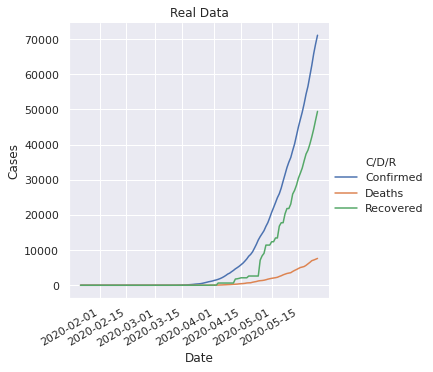

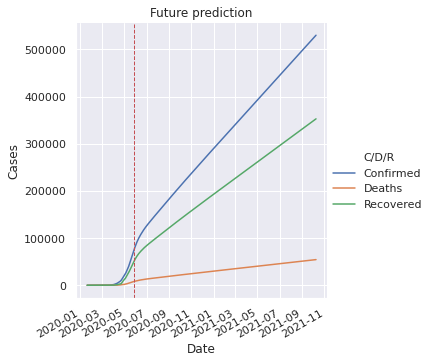

In [149]:
print_predict(nn,country,offset=500)

## K-Nearest Neighbours

In this chapter, the implementation of the K-Nearest Neighbours algorithm to solve the regression problem is demonstrated. To make this demonstration more understandable, it is divided in several functions with its explanation above.

### Parameterization and application of KNN regression algorithm

Based on the data set to be analysed, it is necessary to define the set of parameters that better adjusts to the current problem, in order to augment the efficiency and accuracy of the analysis.
This is achieved by making a grid search, which, through the class' fit function, runs the algorithm several times trying to find the best combination of algorithms, as well as the best score, training the set in the process.

Note that we use Pipeline, this is because GridSearchCV's fit method can receive multiple inputs (X_train) but can only receive a single output (Y_train), that is, can only receive one column, whilst we desire three: 'Confirmed', 'Deaths' and 'Recovered'; using a Pipeline with a StandardScaler and a MultiOutputRegressor allows working with more than one column in the output.

In the following code block, a parameter grid is defined with the parameters and each one's possible values. These correspond to the KNeighborsRegressor's parameters. KNeighborsRegressor is a sklearn class that a adapts a regression model based on k-nearest neighbors.

In order to avoid overfitting we use K-Folds cross-validation.

Once fitting is concluded, we get the best estimator and print its best score and best parameter combination. This estimator is returned.

In [150]:
def knn_by_country_train(
    country,
    input=['Days Since Jan','Population Density (P/Km²)','Urban Population %','Pop %'],
    out= ['Confirmed per million','Deaths per million','Recovered per million'],
):
    df = per_million_nolat.loc[ per_million_nolat['Country/Region'] == country]
    X = df[input].values
    Y = df[out].values

    pipe_svr = Pipeline(
                [
                    ("scl", StandardScaler()),
                    ("knn", MultiOutputRegressor(KNeighborsRegressor()))
                ]
            )

    parameter_grid = {'knn__estimator__n_neighbors': [3,5,7,9,11],
                    'knn__estimator__weights': ['uniform','distance'],
                    'knn__estimator__p' : [1,2,3],
                    'knn__estimator__leaf_size' : [20,25,30,35,40]
                    }

    cross_validation = KFold(n_splits=10)

    grid_search = GridSearchCV(estimator=pipe_svr,
                            param_grid=parameter_grid,
                            cv=cross_validation,
                            n_jobs=-1,
                            return_train_score=True
                            )

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.30,shuffle=True)

    knn = grid_search.fit(X_train, Y_train)
    knn = grid_search.best_estimator_

    print('Best score: {}'.format(knn.score(X_test, Y_test)))
    print('Best parameters: {}'.format(knn))

    return knn

####  Calling the algorithm

In [151]:
country = 'Portugal'
knn = knn_by_country_train(country)

Best score: 0.9468430094226773
Best parameters: Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('knn',
                 MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto',
                                                                    leaf_size=40,
                                                                    metric='minkowski',
                                                                    metric_params=None,
                                                                    n_jobs=None,
                                                                    n_neighbors=3,
                                                                    p=1,
                                                                    weights='distance'),
                                      n_jobs=None))],
         verbose=False)


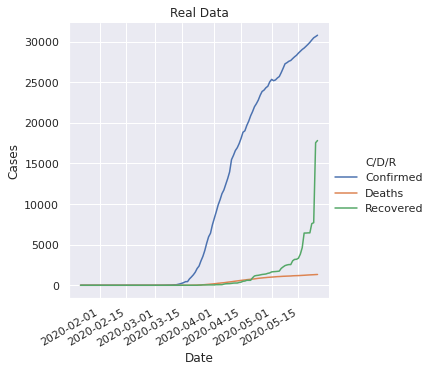

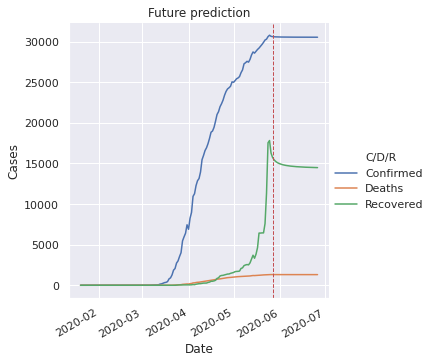

In [153]:
print_predict(knn,country,offset=30)